In [1]:
# Import data science environment.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import sklearn
from sklearn import linear_model
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_style('white')

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='internal gelsd'
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load and preview data set.
cancer = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None, na_values='?')
cancer.dropna()
cancer.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.000,3,1,1,2
1,1002945,5,4,4,5,7,10.000,3,2,1,2
2,1015425,3,1,1,1,2,2.000,3,1,1,2
3,1016277,6,8,8,1,3,4.000,3,7,1,2
4,1017023,4,1,1,3,2,1.000,3,1,1,2


In [3]:
# Create and preview column names.
cancer.columns = ['Code', 'Clump_Thick', 'Unif_Size', 'Unif_Shape', 'Marg_Adh', 'Sng_Epi_Size',
                  'Bare_Nuclei', 'Bland_Chrom', 'Norm_Nuclei', 'Mitoses', 'Class']
cancer.head()

,Code,Clump_Thick,Unif_Size,Unif_Shape,Marg_Adh,Sng_Epi_Size,Bare_Nuclei,Bland_Chrom,Norm_Nuclei,Mitoses,Class
0,1000025,5,1,1,1,2,1.000,3,1,1,2
1,1002945,5,4,4,5,7,10.000,3,2,1,2
2,1015425,3,1,1,1,2,2.000,3,1,1,2
3,1016277,6,8,8,1,3,4.000,3,7,1,2
4,1017023,4,1,1,3,2,1.000,3,1,1,2


In [4]:
# View central tendencies.
cancer.describe()

,Code,Clump_Thick,Unif_Size,Unif_Shape,Marg_Adh,Sng_Epi_Size,Bare_Nuclei,Bland_Chrom,Norm_Nuclei,Mitoses,Class
count,699.000,699.000,699.000,699.000,699.000,699.000,683.000,699.000,699.000,699.000,699.000
mean,1071704.099,4.418,3.134,3.207,2.807,3.216,3.545,3.438,2.867,1.589,2.690
std,617095.730,2.816,3.051,2.972,2.855,2.214,3.644,2.438,3.054,1.715,0.951
min,61634.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000
25%,870688.500,2.000,1.000,1.000,1.000,2.000,1.000,2.000,1.000,1.000,2.000
50%,1171710.000,4.000,1.000,1.000,1.000,2.000,1.000,3.000,1.000,1.000,2.000
75%,1238298.000,6.000,5.000,5.000,4.000,4.000,6.000,5.000,4.000,1.000,4.000
max,13454352.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,4.000


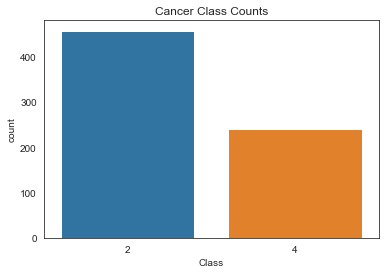

2    458
4    241
Name: Class, dtype: int64

In [5]:
# View value counts.
sns.countplot('Class', data=cancer)
plt.title('Cancer Class Counts')
plt.show()
pd.value_counts(cancer['Class'])

In [6]:
# Let's check for missing data.
cancer.isnull().sum()

Code             0
Clump_Thick      0
Unif_Size        0
Unif_Shape       0
Marg_Adh         0
Sng_Epi_Size     0
Bare_Nuclei     16
Bland_Chrom      0
Norm_Nuclei      0
Mitoses          0
Class            0
dtype: int64

In [7]:
# There are 16 missing values, so let's get rid of them.
cancer.dropna(subset=['Bare_Nuclei'], inplace=True)
cancer.isnull().sum()

Code            0
Clump_Thick     0
Unif_Size       0
Unif_Shape      0
Marg_Adh        0
Sng_Epi_Size    0
Bare_Nuclei     0
Bland_Chrom     0
Norm_Nuclei     0
Mitoses         0
Class           0
dtype: int64

4    350
2    350
Name: Class, dtype: int64

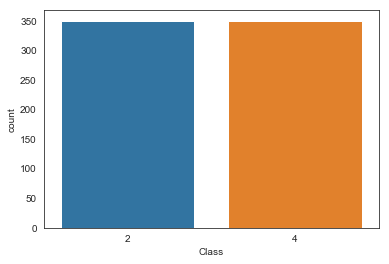

In [8]:
# Let's resample the data.
from sklearn.utils import resample
# Separate majority and minority classes.
benign = cancer[cancer.Class==2]
malignant = cancer[cancer.Class==4]

# Upsample minority class.
malignant_upsampled = resample(malignant,
                               replace=True,
                               n_samples=350,
                               random_state=15)

# Downsample majority class.
benign_downsampled = resample(benign,
                              replace=True,
                              n_samples=350,
                              random_state=15)

# Combine upsampled minority class and downsampled majority class.
cancer_sampled = pd.concat([malignant_upsampled, benign_downsampled])

# Display new class counts.
sns.countplot('Class', data=cancer_sampled)
cancer_sampled.Class.value_counts()

In [9]:
cancer_sampled.describe()

,Code,Clump_Thick,Unif_Size,Unif_Shape,Marg_Adh,Sng_Epi_Size,Bare_Nuclei,Bland_Chrom,Norm_Nuclei,Mitoses,Class
count,700.000,700.000,700.000,700.000,700.000,700.000,700.000,700.000,700.000,700.000,700.000
mean,1089106.131,5.043,4.039,4.150,3.613,3.831,4.480,4.050,3.503,1.843,3.000
std,777442.795,2.923,3.433,3.321,3.217,2.488,3.957,2.673,3.352,2.056,1.001
min,63375.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000
25%,873549.000,3.000,1.000,1.000,1.000,2.000,1.000,2.000,1.000,1.000,2.000
50%,1171710.000,5.000,3.000,3.000,2.000,3.000,2.000,3.000,1.000,1.000,3.000
75%,1241035.000,8.000,7.000,7.000,6.000,5.000,10.000,7.000,6.000,1.000,4.000
max,13454352.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,4.000


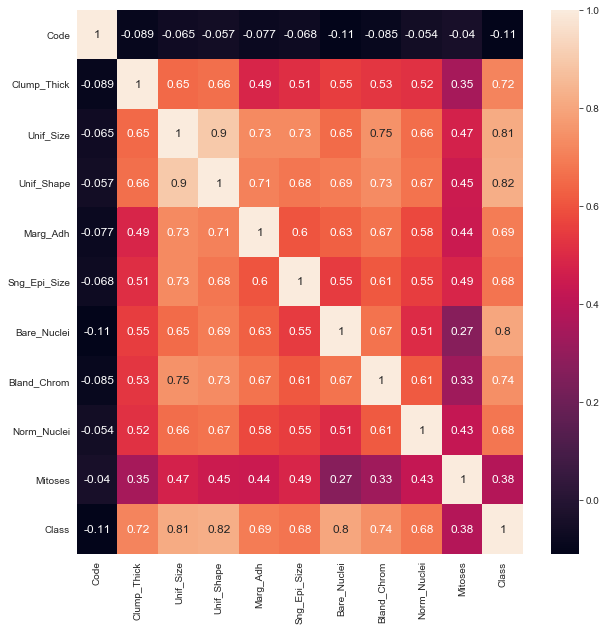

In [10]:
# Run heatmap to check for variable correlations.
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cancer_sampled.corr(), annot=True, annot_kws={"size": 12})

It appears that there is not any correlation with the 'Code' column and any others, which makes sense because it should be a random value.  All other variables have some sort of correlation, with many values above 80%.

In [11]:
# Split data into classes and training groups.
X = cancer_sampled.drop(['Class'], 1)
y = cancer_sampled.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

After attempting to run the Naive Bayes model, a ValueError occured regarding turning a string to a float (?).  After looking at the data set documentation, there are sixteen missing values that are represented by a '?'.  We will need to eliminate these values.

After addressing the null values, I then realized that I need to do some preprocessing (Naive Bayes cross-validation scores averaged 47.29%).  Let's run PCA.

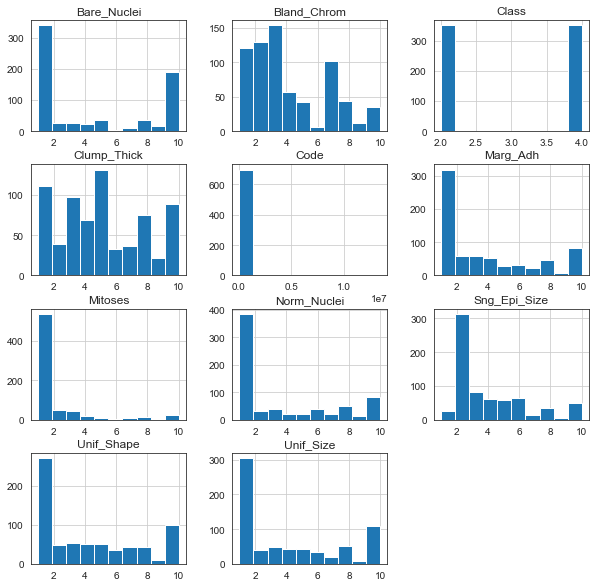

In [12]:
# Visualize the data.
hist = cancer_sampled.hist(bins=10,figsize =(10,10))

In [13]:
# Drop 'Code' column for better view of relevant data.
cancer_box = cancer_sampled.drop(['Code'], 1)

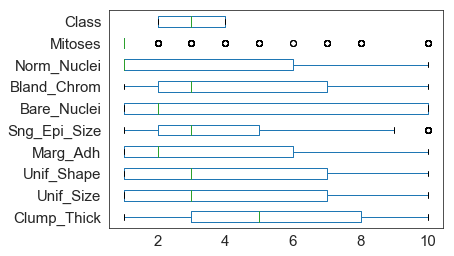

In [14]:
# Visualize outliers/deviations.
boxplot = cancer_box.boxplot(grid=False, vert=False,fontsize=15)

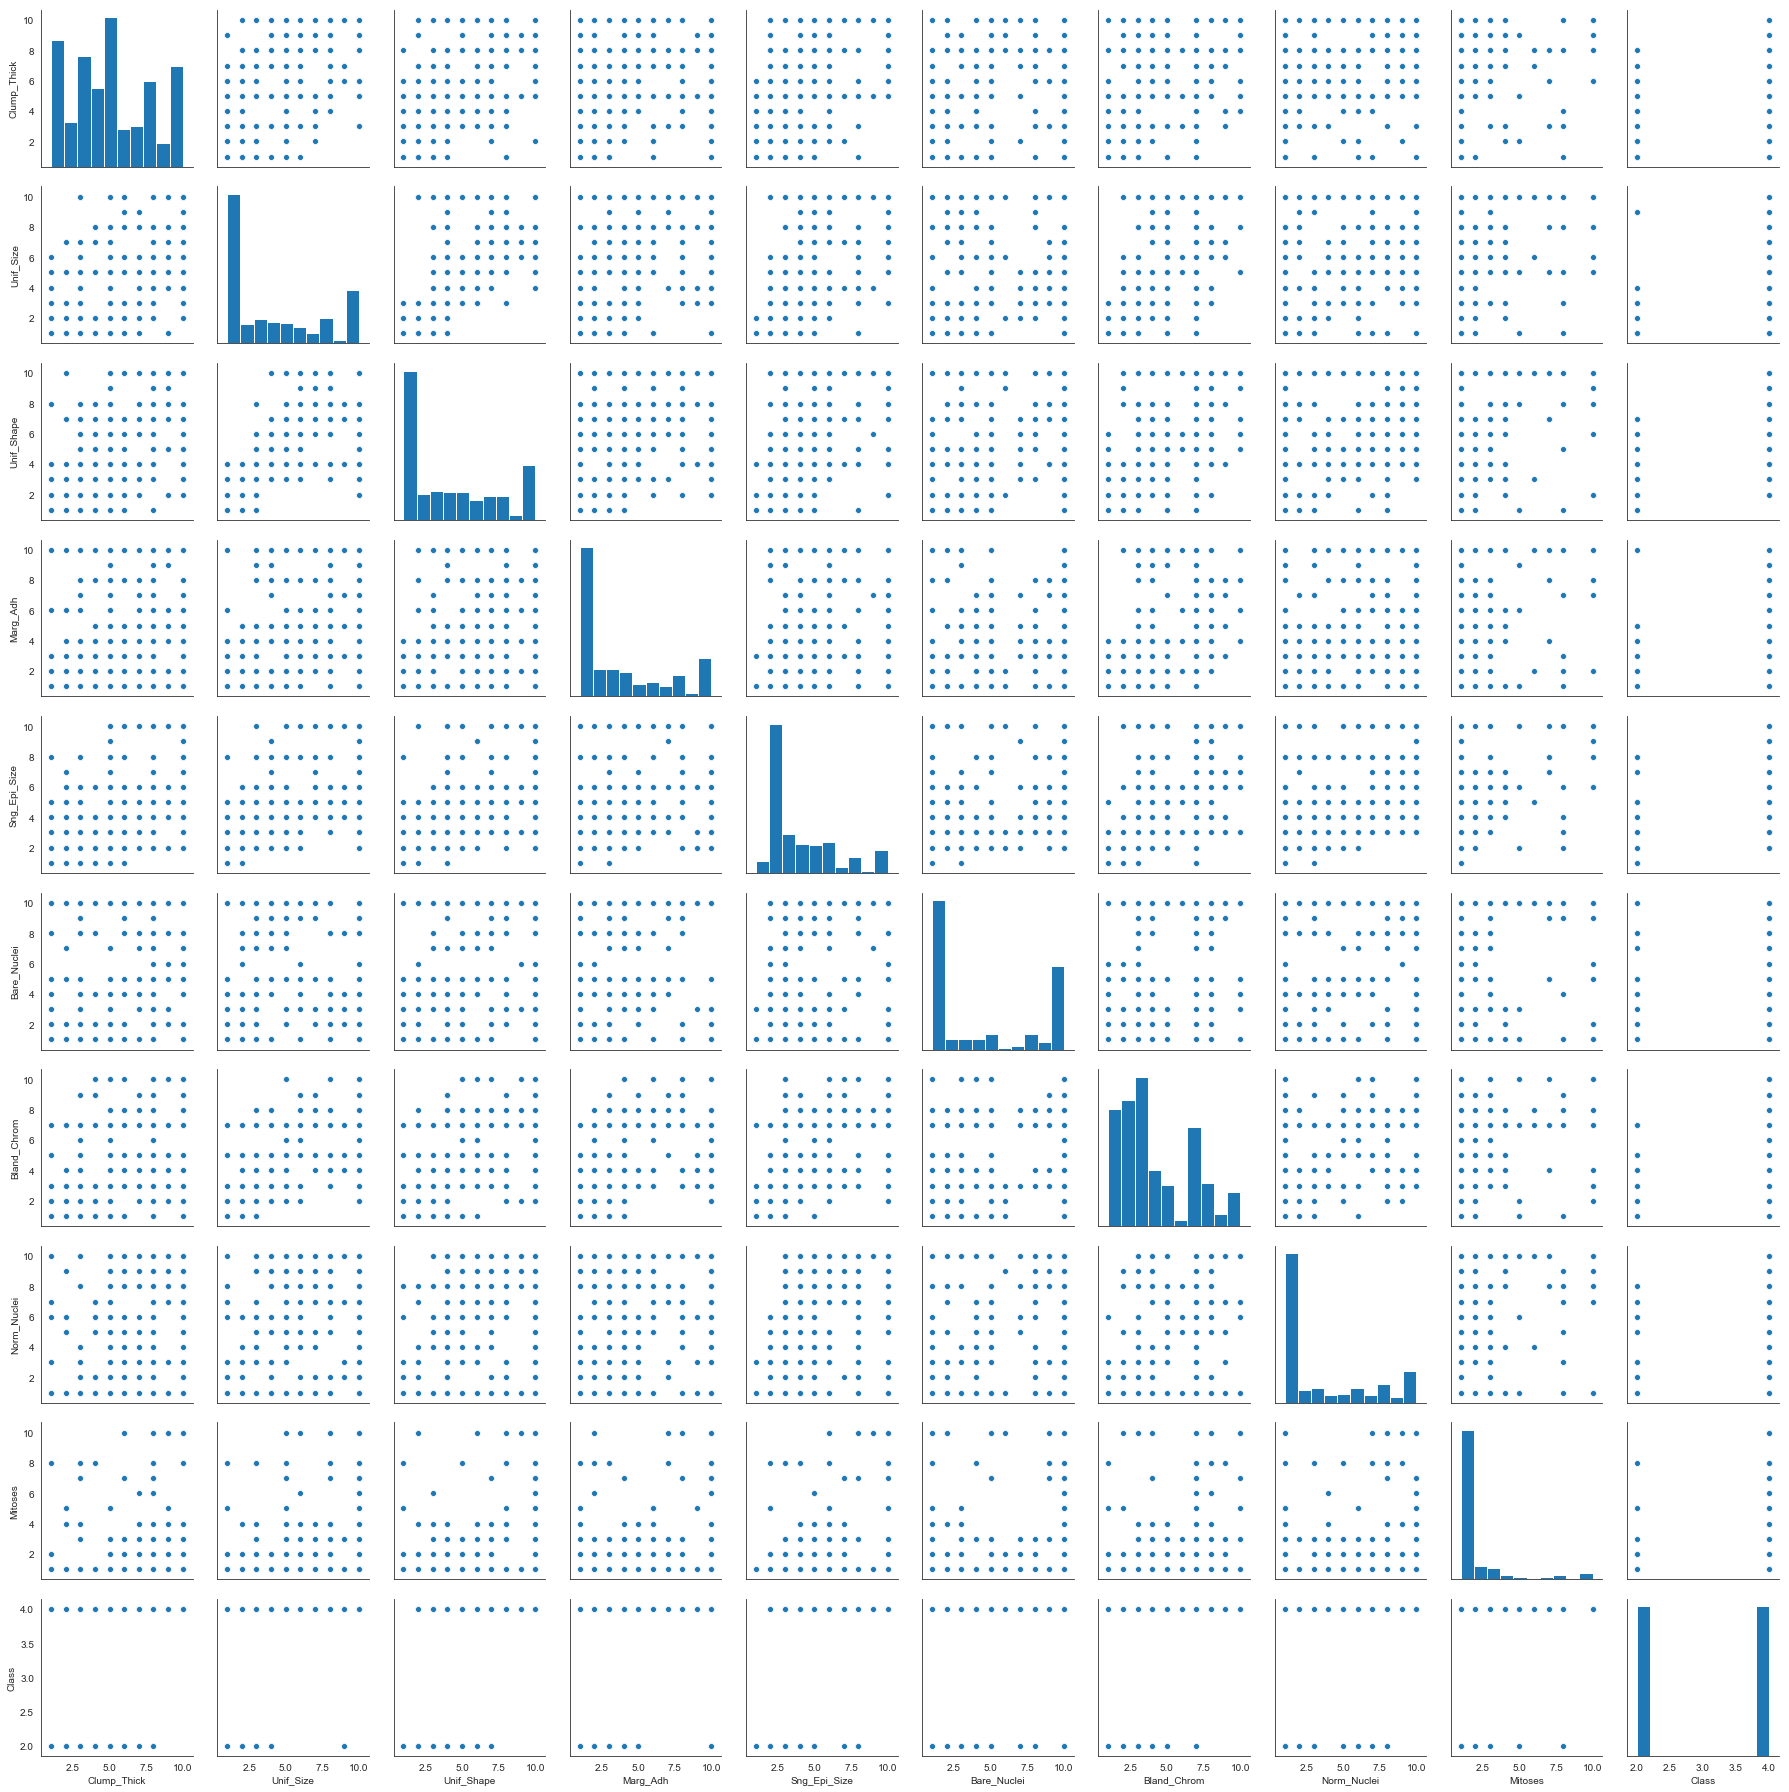

In [15]:
# Pairplot for correlations.
g = sns.pairplot(cancer_box)

In [16]:
# Naive Bayes.
gnb = GaussianNB()
# Fit the model.
gnb.fit(X_train, y_train)
print(gnb)
y_pred_gnb = gnb.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_gnb)
# Cross-validation.
gnb_score = cross_val_score(gnb, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(gnb_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_gnb))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_gnb))

GaussianNB(priors=None, var_smoothing=1e-09)
Cross-Validation Scores: [0.51428571 0.52857143 0.48571429 0.44285714 0.44285714 0.45714286
 0.48571429 0.44285714 0.45714286 0.47142857]
Averaged Cross-Validation Scores: 47.29%.
              precision    recall  f1-score   support

           2       0.38      0.03      0.06       100
           4       0.42      0.93      0.58        75

   micro avg       0.42      0.42      0.42       175
   macro avg       0.40      0.48      0.32       175
weighted avg       0.39      0.42      0.28       175

[[ 3 97]
 [ 5 70]]


The Naive-Bayes model seems to be a fairly poor model.  With under 50% averaged cross-validation scores, one would expect a better result by flipping a coin!

In [17]:
# Build the KNN model.
knn = neighbors.KNeighborsClassifier(n_neighbors=7)
# Fit the model.
knn.fit(X_train, y_train)
print(knn)
y_pred_knn = knn.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_knn)
# Cross-validation.
knn_score = cross_val_score(knn, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(knn_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(knn_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_knn))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_knn))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')
Cross-Validation Scores: [0.62857143 0.45714286 0.58571429 0.64285714 0.55714286 0.62857143
 0.62857143 0.58571429 0.55714286 0.62857143]
Averaged Cross-Validation Scores: 59.00%.
              precision    recall  f1-score   support

           2       0.65      0.49      0.56       100
           4       0.49      0.65      0.56        75

   micro avg       0.56      0.56      0.56       175
   macro avg       0.57      0.57      0.56       175
weighted avg       0.58      0.56      0.56       175

[[49 51]
 [26 49]]


The KNN model is slightly better, but still not good enough to use for prediction with averaged cross-validation scores of 59%.

In [18]:
# Build the Decision Tree model.
# Import tools.
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

dtc = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state=15
)
# Fit the model.
dtc.fit(X_train, y_train)
print(dtc)
y_pred_dtc = dtc.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_dtc)
# Cross-validation.
dtc_score = cross_val_score(dtc, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(dtc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(dtc_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_dtc))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_dtc))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=15, splitter='best')
Cross-Validation Scores: [0.97142857 0.94285714 0.94285714 0.98571429 1.         0.94285714
 0.94285714 0.97142857 0.98571429 0.98571429]
Averaged Cross-Validation Scores: 96.71%.
              precision    recall  f1-score   support

           2       0.98      0.93      0.95       100
           4       0.91      0.97      0.94        75

   micro avg       0.95      0.95      0.95       175
   macro avg       0.95      0.95      0.95       175
weighted avg       0.95      0.95      0.95       175

[[93  7]
 [ 2 73]]


The Decision Tree Classifier yields much better results!  An averaged cross-validation score of 96.71% does not appear to overfit, and the values are consistently above 94%.  This is a very strong model!

In [19]:
# Build the Random Forest model.
# Import tools.
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
# Fit the model.
rfc.fit(X_train, y_train)
print(rfc)
y_pred_rfc = rfc.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_rfc)
# Cross-validation.
rfc_score = cross_val_score(rfc, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(rfc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(rfc_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_rfc))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_rfc))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Cross-Validation Scores: [0.97142857 0.97142857 0.97142857 0.98571429 1.         1.
 0.97142857 1.         1.         1.        ]
Averaged Cross-Validation Scores: 98.71%.
              precision    recall  f1-score   support

           2       0.99      0.95      0.97       100
           4       0.94      0.99      0.96        75

   micro avg       0.97      0.97      0.97       175
   macro avg       0.96      0.97      0.97       175
weighted avg       0.97      0.97      0.97       175

[[95  5]
 [ 1 74]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The Random Forest model is another very strong model.  The averaged cross-validation score is 98.57%, with 60% of the results at 100% and 80% of the results above 98%.  

In [20]:
# Build the Logistic Regression model.
lr = LogisticRegression(C=1e9)
# Fit the model.
lr.fit(X_train, y_train)
print(lr)
y_pred_lr = lr.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_lr)
# Cross-validation.
lr_score = cross_val_score(lr, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(lr_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(lr_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_lr))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_lr))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Cross-Validation Scores: [0.91428571 0.92857143 0.97142857 0.97142857 0.94285714 0.95714286
 0.94285714 1.         0.97142857 0.97142857]
Averaged Cross-Validation Scores: 95.71%.
              precision    recall  f1-score   support

           2       0.99      0.90      0.94       100
           4       0.88      0.99      0.93        75

   micro avg       0.94      0.94      0.94       175
   macro avg       0.93      0.94      0.94       175
weighted avg       0.94      0.94      0.94       175

[[90 10]
 [ 1 74]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

The Logistic Regression model is also a very good model, although not as strong as the Decision Tree or Random Forest models.  With a 95.71% averaged cross-validation and a standard deviation of less than 5, this is another strong model.

In [21]:
# Build the SVC model.
svc = LinearSVC()
# Fit the model.
svc.fit(X_train, y_train)
print(svc)
y_pred_svc = svc.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_svc)
# Cross-validation.
svc_score = cross_val_score(svc, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(svc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(svc_score.mean()))
# Classification score.
print(classification_report(y_test, y_pred_svc))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_svc))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Cross-Validation Scores: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Averaged Cross-Validation Scores: 50.00%.
              precision    recall  f1-score   support

           2       0.57      1.00      0.73       100
           4       0.00      0.00      0.00        75

   micro avg       0.57      0.57      0.57       175
   macro avg       0.29      0.50      0.36       175
weighted avg       0.33      0.57      0.42       175

[[100   0]
 [ 75   0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being s

The SVC model is not performing well at all. 50% is no better than guessing!

In [22]:
# Build the Gradient Boosting model.
gbm = ensemble.GradientBoostingClassifier()
# Fit the model.
gbm.fit(X_train, y_train)
print(gbm)
y_pred_gbm = gbm.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_gbm)
# Cross-validation.
gbm_score = cross_val_score(gbm, X, y, cv=10)
print('Cross-Validation Scores: {}'.format(gbm_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(gbm_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_gbm))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_gbm))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Cross-Validation Scores: [0.98571429 0.97142857 0.98571429 0.98571429 1.         0.98571429
 0.95714286 1.         1.         1.        ]
Averaged Cross-Validation Scores: 98.71%.
              precision    recall  f1-score   support

           2       0.99      0.94      0.96       100
           4       0.93      0.99      0.95        75

   micro avg       0.96      0.96      0.96       175
   macro avg       0.96      0.96      0.96       175
wei

The Gradient Boosting model is an exceptionally strong model, similarly to the Random Forest model (but only 40% of the results are at 100%).

In [23]:
print('Naive Bayes Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_score.mean()))
print('K-Nearest Neighbors Averaged Cross-Validation Scores: {:.2%}.'.format(knn_score.mean()))
print('Decision Tree Averaged Cross-Validation Scores: {:.2%}.'.format(dtc_score.mean()))
print('Random Forest Averaged Cross-Validation Scores: {:.2%}.'.format(rfc_score.mean()))
print('Logistic Regression Averaged Cross-Validation Scores: {:.2%}.'.format(lr_score.mean()))
print('Linear Support Vector Averaged Cross-Validation Score: {:.2%}.'.format(svc_score.mean()))
print('Gradient Boosting Averaged Cross-Validation Score: {:.2%}.'.format(gbm_score.mean()))

Naive Bayes Averaged Cross-Validation Scores: 47.29%.
K-Nearest Neighbors Averaged Cross-Validation Scores: 59.00%.
Decision Tree Averaged Cross-Validation Scores: 96.71%.
Random Forest Averaged Cross-Validation Scores: 98.71%.
Logistic Regression Averaged Cross-Validation Scores: 95.71%.
Linear Support Vector Averaged Cross-Validation Score: 50.00%.
Gradient Boosting Averaged Cross-Validation Score: 98.71%.


It appears that the Gradient Boosting, Random Forest, Decision Tree, and Logistic Regression models are the four best models.  Naive Bayes, Linear Support Vector, and the K-Nearest Neighbors models are all underfitting. Let's see if adding SelectKBest will help any of the under-performing models.

In [24]:
# SelectKBest model.
# Import tools.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=7)
selector.fit(X, y)

X_skbest = selector.transform(X)
print(X_skbest.shape)

X.columns[selector.get_support(indices=True)].tolist()

(700, 7)


['Code',
 'Unif_Size',
 'Unif_Shape',
 'Marg_Adh',
 'Bare_Nuclei',
 'Bland_Chrom',
 'Norm_Nuclei']

These are the seven most important features.  Let's try using just these seven features as our X. I will see if only using these features will improve the models that are not performing well.

In [25]:
# Run Naive Bayes model with SelectKBest.
gnb.fit(X_skbest, y)
y_pred_gnb = gnb.predict(X_skbest)
gnb_score_skbest = cross_val_score(gnb, X_skbest, y, cv=10)
print('Cross-Validation Scores: {}'.format(gnb_score_skbest))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_score_skbest.mean()))

Cross-Validation Scores: [0.51428571 0.51428571 0.48571429 0.44285714 0.44285714 0.45714286
 0.48571429 0.44285714 0.45714286 0.47142857]
Averaged Cross-Validation Scores: 47.14%.


In [26]:
# Run KNN model with SelectKBest.
knn.fit(X_skbest, y)
y_pred_knn = knn.predict(X_skbest)
knn_score_skbest = cross_val_score(knn, X_skbest, y, cv=10)
print('Cross-Validation Scores: {}'.format(knn_score_skbest))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(knn_score_skbest.mean()))

Cross-Validation Scores: [0.62857143 0.45714286 0.58571429 0.64285714 0.55714286 0.62857143
 0.62857143 0.58571429 0.55714286 0.62857143]
Averaged Cross-Validation Scores: 59.00%.


In [27]:
# Run SVC model with SelectKBest.
svc.fit(X_skbest, y)
y_pred_svc = svc.predict(X_skbest)
svc_score_skbest = cross_val_score(svc, X_skbest, y, cv=10)
print('Cross-Validation Scores: {}'.format(svc_score_skbest))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(svc_score_skbest.mean()))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Cross-Validation Scores: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Averaged Cross-Validation Scores: 50.00%.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [28]:
# Let's compare the models with their SelectKBest alternatives.
print('Naive Bayes Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_score.mean()))
print('Naive Bayes SKBest Averaged Cross-Validation Scores: {:.2%}.\n'.format(gnb_score_skbest.mean()))
print('K-Nearest Neighbors Averaged Cross-Validation Scores: {:.2%}.'.format(knn_score.mean()))
print('K-Nearest Neighbors SKBest Averaged Cross-Validation Scores: {:.2%}.\n'.format(knn_score_skbest.mean()))
print('Linear Support Vector Averaged Cross-Validation Scores: {:.2%}.'.format(svc_score.mean()))
print('Linear Support Vector SKBest Averaged Cross-Validation Scores: {:.2%}.'.format(svc_score_skbest.mean()))

Naive Bayes Averaged Cross-Validation Scores: 47.29%.
Naive Bayes SKBest Averaged Cross-Validation Scores: 47.14%.

K-Nearest Neighbors Averaged Cross-Validation Scores: 59.00%.
K-Nearest Neighbors SKBest Averaged Cross-Validation Scores: 59.00%.

Linear Support Vector Averaged Cross-Validation Scores: 50.00%.
Linear Support Vector SKBest Averaged Cross-Validation Scores: 50.00%.


As you can see, the Naive Bayes is the only model that is even slightly affected, but very minimally. Let's try using PCA on all models.

In [29]:
# Set up and run PCA.
pca = PCA(n_components=10)
pca.fit(X)
X_pca = pca.transform(X)

print('Percentage of total variance explained by each component:\n', pca.explained_variance_ratio_)

Percentage of total variance explained by each component:
 [1.00000000e+00 9.48246365e-11 1.17322962e-11 8.13940485e-12
 7.62333777e-12 5.35261648e-12 5.09649591e-12 3.84335705e-12
 3.32960278e-12 1.74912176e-12]


In [30]:
# Run Naive Bayes model with PCA.
gnb_pca = GaussianNB()
gnb_pca.fit(X_pca, y)
print(gnb_pca)
y_pred_gnb = gnb_pca.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_gnb)
# Cross-validation.
gnb_pca_score = cross_val_score(gnb_pca, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(gnb_pca_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_pca_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_gnb))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_gnb))

GaussianNB(priors=None, var_smoothing=1e-09)
Cross-Validation Scores: [0.52857143 0.52857143 0.48571429 0.44285714 0.44285714 0.45714286
 0.48571429 0.44285714 0.45714286 0.47142857]
Averaged Cross-Validation Scores: 47.43%.
              precision    recall  f1-score   support

           2       0.58      0.97      0.73       100
           4       0.67      0.08      0.14        75

   micro avg       0.59      0.59      0.59       175
   macro avg       0.63      0.53      0.44       175
weighted avg       0.62      0.59      0.48       175

[[97  3]
 [69  6]]


In [31]:
# Run KNN model with PCA.
knn_pca = neighbors.KNeighborsClassifier(n_neighbors=7)
knn_pca.fit(X_pca, y)
print(knn_pca)
y_pred_knn = knn_pca.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_knn)
# Cross-validation.
knn_pca_score = cross_val_score(knn_pca, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(knn_pca_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(knn_pca_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_knn))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_knn))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')
Cross-Validation Scores: [0.62857143 0.45714286 0.58571429 0.64285714 0.55714286 0.62857143
 0.62857143 0.58571429 0.55714286 0.62857143]
Averaged Cross-Validation Scores: 59.00%.
              precision    recall  f1-score   support

           2       0.58      1.00      0.74       100
           4       1.00      0.04      0.08        75

   micro avg       0.59      0.59      0.59       175
   macro avg       0.79      0.52      0.41       175
weighted avg       0.76      0.59      0.45       175

[[100   0]
 [ 72   3]]


In [32]:
# Run Decision Tree model with PCA.
dtc_pca = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state=15
)
dtc_pca.fit(X_pca, y)
print(dtc_pca)
y_pred_dtc = dtc_pca.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_dtc)
# Cross-validation.
dtc_pca_score = cross_val_score(dtc_pca, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(dtc_pca_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(dtc_pca_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_dtc))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_dtc))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=15, splitter='best')
Cross-Validation Scores: [0.87142857 0.85714286 0.77142857 0.84285714 0.82857143 0.85714286
 0.85714286 0.71428571 0.82857143 0.82857143]
Averaged Cross-Validation Scores: 82.57%.
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       100
           4       0.43      1.00      0.60        75

   micro avg       0.43      0.43      0.43       175
   macro avg       0.21      0.50      0.30       175
weighted avg       0.18      0.43      0.26       175

[[  0 100]
 [  0  75]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
# Run Random Forest model with PCA.
rfc_pca = ensemble.RandomForestClassifier()
rfc_pca.fit(X_pca, y)
print(rfc_pca)
y_pred_rfc = rfc_pca.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_rfc)
# Cross-validation.
rfc_pca_score = cross_val_score(rfc_pca, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(rfc_pca_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(rfc_pca_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_rfc))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_rfc))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross-Validation Scores: [1.         0.97142857 0.97142857 1.         1.         0.98571429
 0.97142857 1.         1.         1.        ]
Averaged Cross-Validation Scores: 99.00%.
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       100
           4       0.43      1.00      0.60        75

   micro avg       0.43      0.43      0.43       175
   macro avg       0.21      0.50      0.30       175
weighted avg       0.18      0.43      0.26       175

[[  0 100]
 [  0  75]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
# Run Logistic Regression model with PCA.
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_pca, y)
print(lr_pca)
y_pred_lr = lr_pca.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_lr)
# Cross-validation.
lr_pca_score = cross_val_score(lr_pca, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(lr_pca_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(lr_pca_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_lr))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_lr))

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Cross-Validation Scores: [0.95714286 0.94285714 0.94285714 0.98571429 0.97142857 0.94285714
 0.95714286 0.98571429 0.98571429 1.        ]
Averaged Cross-Validation Scores: 96.71%.
              precision    recall  f1-score   support

           2       0.74      0.88      0.80       100
           4       0.79      0.59      0.67        75

   micro avg       0.75      0.75      0.75       175
   macro avg       0.76      0.73      0.74       175
weighted avg       0.76      0.75      0.75       175

[[88 12]
 [31 44]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

In [35]:
# Run SVC model with PCA.
svc_pca = LinearSVC()
svc_pca.fit(X_pca, y)
print(svc_pca)
y_pred_svc = svc_pca.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_svc)
# Cross-validation.
svc_pca_score = cross_val_score(svc_pca, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(svc_pca_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(svc_pca_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_svc))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_svc))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Cross-Validation Scores: [0.52857143 0.48571429 0.57142857 0.5        0.47142857 0.44285714
 0.57142857 0.44285714 0.42857143 0.57142857]
Averaged Cross-Validation Scores: 50.14%.
              precision    recall  f1-score   support

           2       0.57      1.00      0.73       100
           4       0.00      0.00      0.00        75

   micro avg       0.57      0.57      0.57       175
   macro avg       0.29      0.50      0.36       175
weighted avg       0.33      0.57      0.42       175

[[100   0]
 [ 75   0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being s

In [36]:
# Run Gradient Boosting model with PCA.
gbm_pca = ensemble.GradientBoostingClassifier()
gbm_pca.fit(X_pca, y)
print(gbm_pca)
y_pred_gbm = gbm_pca.predict(X_test)
# Accuracy score.
accuracy_score(y_test, y_pred_gbm)
# Cross-validation.
gbm_pca_score = cross_val_score(gbm_pca, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(gbm_pca_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(gbm_pca_score.mean()))
# Classification report.
print(classification_report(y_test, y_pred_gbm))
# Confusion matrix.
print(confusion_matrix(y_test, y_pred_gbm))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Cross-Validation Scores: [0.98571429 0.97142857 0.98571429 1.         1.         1.
 0.97142857 1.         1.         1.        ]
Averaged Cross-Validation Scores: 99.14%.
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       100
           4       0.42      0.97      0.59        75

   micro avg       0.42      0.42      0.42       175
   macro avg       0.21      0.49      0.29       175
weighted av

It does not appear that the PCA models are affecting the models much. Let's print results to compare more easily.

In [37]:
print('Naive Bayes Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_score.mean()))
print('K-Nearest Neighbors Averaged Cross-Validation Scores: {:.2%}.'.format(knn_score.mean()))
print('Decision Tree Averaged Cross-Validation Scores: {:.2%}.'.format(dtc_score.mean()))
print('Random Forest Averaged Cross-Validation Scores: {:.2%}.'.format(rfc_score.mean()))
print('Logistic Regression Averaged Cross-Validation Scores: {:.2%}.'.format(lr_score.mean()))
print('Linear Support Vector Averaged Cross-Validation Score: {:.2%}.'.format(svc_score.mean()))
print('Gradient Boosting Averaged Cross-Validation Score: {:.2%}.\n'.format(gbm_score.mean()))

print('Naive Bayes PCA Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_pca_score.mean()))
print('K-Nearest Neighbors PCA Averaged Cross-Validation Scores: {:.2%}.'.format(knn_pca_score.mean()))
print('Decision Tree PCA Averaged Cross-Validation Scores: {:.2%}.'.format(dtc_pca_score.mean()))
print('Random Forest PCA Averaged Cross-Validation Scores: {:.2%}.'.format(rfc_pca_score.mean()))
print('Logistic Regression PCA Averaged Cross-Validation Scores: {:.2%}.'.format(lr_pca_score.mean()))
print('Linear Support Vector PCA Averaged Cross-Validation Score: {:.2%}.'.format(svc_pca_score.mean()))
print('Gradient Boosting PCA Averaged Cross-Validation Score: {:.2%}.'.format(gbm_pca_score.mean()))

Naive Bayes Averaged Cross-Validation Scores: 47.29%.
K-Nearest Neighbors Averaged Cross-Validation Scores: 59.00%.
Decision Tree Averaged Cross-Validation Scores: 96.71%.
Random Forest Averaged Cross-Validation Scores: 98.71%.
Logistic Regression Averaged Cross-Validation Scores: 95.71%.
Linear Support Vector Averaged Cross-Validation Score: 50.00%.
Gradient Boosting Averaged Cross-Validation Score: 98.71%.

Naive Bayes PCA Averaged Cross-Validation Scores: 47.43%.
K-Nearest Neighbors PCA Averaged Cross-Validation Scores: 59.00%.
Decision Tree PCA Averaged Cross-Validation Scores: 82.57%.
Random Forest PCA Averaged Cross-Validation Scores: 99.00%.
Logistic Regression PCA Averaged Cross-Validation Scores: 96.71%.
Linear Support Vector PCA Averaged Cross-Validation Score: 50.14%.
Gradient Boosting PCA Averaged Cross-Validation Score: 99.14%.


In conclusion, the best models appear to be the Gradient Boosting, Random Forest, Logistic Regression, and Decision Tree. Naive Bayes, K-Nearest Neighbors, and Linear Support Vector models did not perform adequately. PCA and SelectKBest didn't seem to have a significant effect on the performance of the models. If I had to choose one model to use, I would try the Random Forest model, as it only had 5 misses out of 175 instances. With regard to what traits are most indicative of whether or not an individual will be diagnosed, the top three traits correlated with the class are the Unif_Shape, Unif_Size, and Bare_Nuclei, being correct a respective 82%, 81%, and 80% of the time. The next most effective traits would be Bland_Chrom (74%), Clump_Thick (72%), Marg_Adh (69%), Sng_Epi_Size and Norm_Nuclei (68%), Mitosis (38%), and Code (-11%).

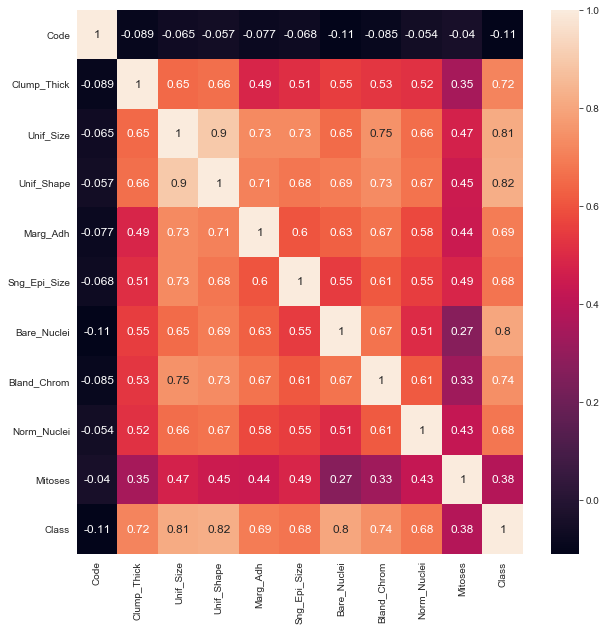

In [38]:
# Reshow heatmap with percentages to justify which traits are most effective.
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cancer_sampled.corr(), annot=True, annot_kws={"size": 12})